## Primero, leemos los datos y los mostramos

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
from scipy import signal
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm

In [3]:
from importlib import reload

import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.tools
reload(spectral_analysis.tools)
from spectral_analysis.tools.spectral_analysis_tools import open_ds_kwe,calc_bm_igw_k

import spectral_analysis.isotropic_spectra
reload(spectral_analysis.isotropic_spectra)
import spectral_analysis.isotropic_spectra.wf_spectrum
reload(spectral_analysis.isotropic_spectra.wf_spectrum)
from spectral_analysis.isotropic_spectra.wf_spectrum import spec_est3 as spec3d

import spectral_analysis.common_vars.regions
reload(spectral_analysis.common_vars.regions)

import spectral_analysis.luigi_workflows.output
reload(spectral_analysis.luigi_workflows.output)

from spectral_analysis.luigi_workflows.output import uv4idt,UV4id,VorticityGrid

In [4]:
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER
fname_var_fmt = LUIGI_OUT_FOLDER+"/Datasets_compressed/{0}/{1}/{2}0_{3:05d}.npz"
fname_grid_fmt = LUIGI_OUT_FOLDER+"/Datasets_compressed/{0}/hours/{1}.txt"
spectra_fn_fmt = LUIGI_OUT_FOLDER+"/spectra/{0}/{1}_{2}_{3}.npz"

In [5]:
from spectral_analysis.common_vars.regions import ids_regions,all_ids
from spectral_analysis.common_vars.time_slices import idx_t,seasons
all_t_res = list(idx_t.keys())

In [ ]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

In [6]:
def detrend(S):
	S = signal.detrend(S,axis=0,type='linear')
	S = signal.detrend(S,axis=1,type='linear')
	S = signal.detrend(S,axis=2,type='linear')
	return S

In [7]:
def centerIdx(length):
	if length%2==1:
		return int((length-1)/2+1)
	else:
		return int(length/2)

In [8]:
def calc_ispec(E,k,l,om):
	""" calculates isotropic spectrum from 3D spectrum """

	print("Input shapes: E,k,l,f",E.shape,k.shape,l.shape,om.shape)

	dk,dl = k[1]-k[0],l[1]-l[0]
	l,k = np.meshgrid(l,k)
	wv = np.sqrt(k**2 + l**2)
	print("Grid shapes: k,l,K",k.shape,l.shape,wv.shape)

	if k.max()>l.max():
		kmax = l.max()
		dkr = dl
	else:
		kmax = k.max()
		dkr = dk

	y,x = np.indices(E.shape[:-1])
	print("Indices shape: x,y",x.shape,y.shape)
	cx = centerIdx(np.max(x)+1)
	cy = centerIdx(np.max(y)+1)
	kr_bins_flat = (np.sqrt((x-cx)**2 + (y-cy)**2)).astype(np.int).ravel() # Medimos la distancia en múltiplos de dkr
	nr = np.bincount(kr_bins_flat)
	nbins = int(np.round(kmax/dkr))
	print("Nbins",nbins)

	# create radial wavenumber
	#dkr = np.sqrt(dk**2 + dl**2)
	#kr =  np.arange(nbins)*dkr # Bin edges
	kr =  np.arange(nbins)*dkr+dkr/2 # Bin centers

	for iw in range(om.size):
		E_ = E[:,:,iw]


		# Isotropization w/ radial profile (See https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile)
		Ei = (np.bincount(kr_bins_flat,E_.ravel())/nr)[:nbins]

		if False:
			if (iw-1)%5==0:
				plt.clf()
				fig, ax = plt.subplots(1,2,figsize=(15,6))
				ax = ax.flat[:]
				plt.sca(ax[0])
				plt.pcolormesh(k,l,E_,cmap='rainbow',norm = LogNorm())
				plt.colorbar()
				plt.sca(ax[1])
				plt.semilogy(kr,Ei)
				plt.suptitle("Freq = {0:0.4f} cph, T = {1:0.1f} hours".format(om[iw],1/om[iw]),size="xx-large")
				plt.show()

		# Isotropization - Original way
		#Ei = np.zeros(kr.size)
		#for ik in range(kr.size):
		#    Kr_min = kr[ik]-dkr/2
		#    Kr_max = kr[ik]+dkr/2
		#    fkr =  (wv>=Kr_min) & (wv<Kr_max)
		#    dth = np.pi / (fkr.sum()-1)
		#    #Area_ik = np.pi*(Kr_max**2 - Kr_min**2)
		#    Ei[ik] = E_[fkr].sum() * kr[ik] * dth #np.mean(E_[fkr])

		# Storage
		if iw == 0:
			Eiso = np.zeros((nbins,om.size))
		Eiso[:,iw] = Ei

	return kr[:nbins], Eiso[:nbins,:]

In [9]:
def isospec_save(S,k,l,om,region_id,var,season,t_res):
	logging.debug("{} - S shape: {}".format(var,S.shape))
	logging.debug("k,l,om shapes: {},{},{}".format(k.shape,l.shape,om.shape))
	logging.debug("min,max Spectrum: {},{}".format(np.min(S),np.max(S)))
	
	## Isotropization (azimuthal averaging)
	logging.info("Spectrum isotropization")
	k_iso, S_iso = calc_ispec(S,k,l,om)
	
	## Saving
	fname = spectra_fn_fmt.format(region_id,var,season,t_res)
	os.makedirs(os.path.dirname(fname), exist_ok=True)
	np.savez_compressed(fname,k=k_iso,om=om,S=S_iso)
	logging.info("Saved {}".format(fname))

In [10]:
vars_vel = set(["KE","RV","DIV"])
all_vars = vars_vel ## Por ahora es igual, pero luego se extenderá para tener SSH o algún otro
beta = 1.33/2

def calculate_save_spectrum(region_id,season,var="all_u",t_res="hours"):
	assert t_res in all_t_res,"t_res not in [hours,days]"
	dt_hr = 1 if t_res=="hours" else 24
	
	grid = VorticityGrid(r_id)
	dx,dy = np.mean(grid.dxg.flatten()),np.mean(grid.dyg.flatten()) # En metros
	dx,dy,dt = dx/1000,dy/1000,dt_hr # En (km,km,hr)
	logging.debug("dx,dy,dt: {},{},{}".format(dx,dy,dt))
	
	# Variable validation
	if var=="all":
		var = all_vars
	elif isinstance(var,str):
		var = [var]
	vars_int = list(vars_vel & set(var)) # Only vars in vars_vel are processed
	
	if vars_int:
		logging.info("** Calculating spectra for {}".format(vars_int))
		logging.info("Loading U,V fields")
		U,V = UV4id(region_id,season,t_res,True)
		N = U.size
		logging.debug("U,V shapes: {},{} -- total elements: {}".format(U.shape,V.shape,N))
		U,V = detrend(U),detrend(V)
		logging.debug("U,V size in MB: {},{}".format(U.nbytes/(1024**2),V.nbytes/(1024**2)))

		for var_ in vars_int:
			var_ = var_.upper()
			logging.debug(var_)

			if var_=="RV":
				zeta = np.moveaxis(grid.rv(U,V),0,-1)
				S,k,l,om = spec3d(zeta,dx,dy,dt,"RV",beta=beta)

			elif var_=="DIV":
				div = np.moveaxis(grid.div(U,V),0,-1)
				S,k,l,om = spec3d(zeta,dx,dy,dt,"DIV",beta=beta)

			elif var_=="KE":
				U_ = np.moveaxis(U,0,-1)
				V_ = np.moveaxis(V,0,-1)
				EU,k,l,om = spec3d(U_,dx,dy,dt,"U",beta=beta)
				EV,_,_,_ = spec3d(V_,dx,dy,dt,"V",beta=beta)
				del U_,V_

				S = 0.5*(EU+EV)
				del EU,EV

			isospec_save(S,k,l,om,region_id,var_,season,t_res)
			
		del U,V

In [139]:
for id_,season in product(all_ids,seasons):
	calculate_save_spectrum(id_,season,vars_vel)

dx,dy,dt 1.9029611794667736 2.0694955950773455 1
** Calculating spectra for  ['RV', 'KE', 'DIV']
Loading U,V fields
762 2640
UV shape (288, 289, 2184)
U,V shapes (2184, 288, 289) (2184, 288, 289)  -- total elements: 181778688
U,V size in MB 1386.861328125 1386.861328125
RV
RV Energy (x,y,t) 0.05688020111498376
RV Energy (k,l,f) 0.046138992195735445
Dividing by N (total # of elems) to get (approximate) PSD
RV :S shape (288, 289, 1093)
k,l,om shapes (288,) (289,) (1093,)
min,max Spectrum 6.955942688775315e-22 0.00015928040100478358
Spectrum isotropization
Input shapes: E,k,l,f (288, 289, 1093) (288,) (289,) (1093,)
Grid shapes: k,l,K (288, 289) (288, 289) (288, 289)
Indices shape: x,y (288, 289) (288, 289)
Nbins 144
Saved /home/antonio/Tesis/spectra/762/RV_JFM_hours.npz
KE
U Energy (x,y,t) 1215404.4044919573
U Energy (k,l,f) 990266.9316211784
Dividing by N (total # of elems) to get (approximate) PSD
V Energy (x,y,t) 1231990.1209082776
V Energy (k,l,f) 1007779.2658212073
Dividing by N (to

In [11]:
cmap_ranges = {
	"KE": [1e-5,1e-2],
	"RV": [1e-12,1e-9],
	"DIV": [1e-12,1e-9],
	"RVDIV": [0.1,10]
}

def plot_spectra(region_id,seasons,var,t_res="hours"):
	assert t_res in all_t_res,"t_res not in [hours,days]"
	
	fig, ax = plt.subplots(1,2,figsize=(15,6))
	ax = ax.flat[:]

	for j,season in enumerate(seasons):
		logging.debug("{},{}".format(j,season))
		plt.sca(ax[j])
		
		if var=="RVDIV":
			## RV
			fname = spectra_fn_fmt.format(region_id,"RV",season,t_res)
			logging.debug("Loading {}".format(fname))
			rv_loaded = np.load(fname)
			k,om,RV = rv_loaded["k"],rv_loaded["om"][:-150],rv_loaded["S"][:,:-150]
			## DIV
			fname = spectra_fn_fmt.format(region_id,"DIV",season,t_res)
			logging.debug("Loading {}".format(fname))
			div_loaded = np.load(fname)
			DIV = div_loaded["S"][:,:-150]
			logging.info("Calculating DIV/RV")
			S = DIV/RV
			logging.debug("min,max DIV/RV values: {},{}".format(np.min(S),np.max(S)))
		else:
			fname = spectra_fn_fmt.format(region_id,var,season,t_res)
			logging.debug("Loading {}".format(fname))
			s_loaded = np.load(fname)
			k,om,S = s_loaded["k"],s_loaded["om"][:-150],s_loaded["S"][:,:-150]
		
		#print("Horizontal scales (km)",["{:.2f}".format(1/k_) for k_ in k])
		#print("Time scales (h)",["{:.2f}".format(1/om_) for om_ in om])
		logging.debug("Spectra shape: {}".format(S.shape))

		# Plot
		plt.pcolormesh(k,om,(om*S).T*k,cmap='nipy_spectral_r',norm = LogNorm())

		plt.clim(cmap_ranges[var])
		plt.xscale('log')
		plt.xlim([k[1],k[-1]/2.5])
		plt.xticks([1/10,1/50,1/100,1/200],['10','50','100','200'])
		plt.yscale('log')
		plt.ylim([om[1],om[-100]])
		plt.yticks([1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)],['3 h','6 h','12 h','1 d','1 w','1 mo'])
		plt.colorbar()
		plt.title("{}/{}".format(region_id,season))

	plt.show()

0 JFM
Loading /home/antonio/Tesis/spectra/733/KE_JFM_hours.npz
Spectra shape (144, 943)
1 ASO
Loading /home/antonio/Tesis/spectra/733/KE_ASO_hours.npz
Spectra shape (144, 955)


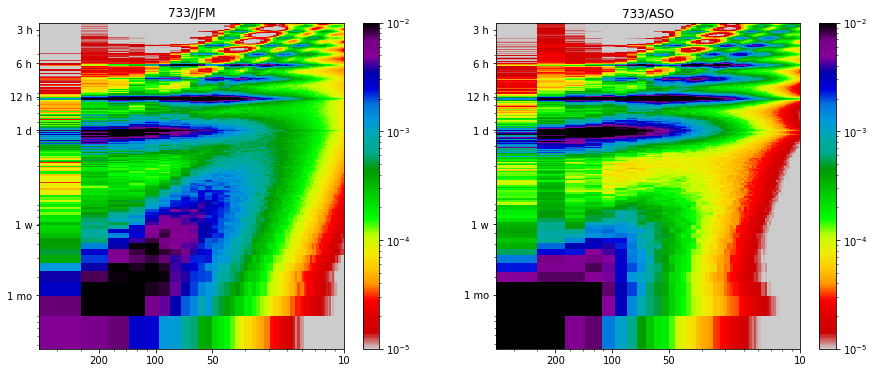

0 JFM
Loading /home/antonio/Tesis/spectra/733/RV_JFM_hours.npz
Spectra shape (144, 943)
1 ASO
Loading /home/antonio/Tesis/spectra/733/RV_ASO_hours.npz
Spectra shape (144, 955)


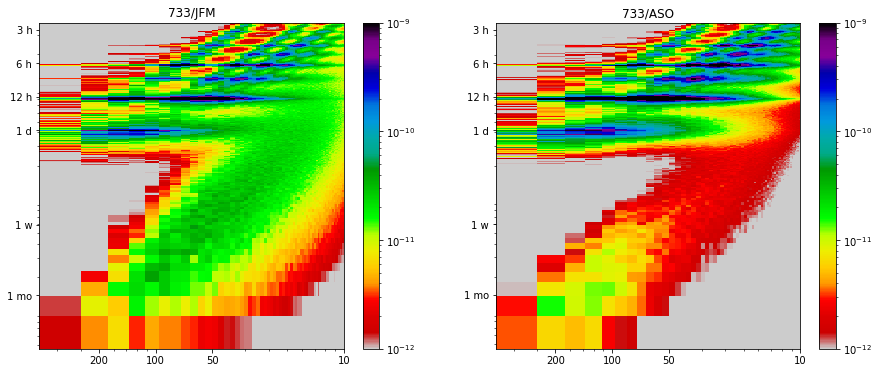

0 JFM
Loading /home/antonio/Tesis/spectra/733/DIV_JFM_hours.npz
Spectra shape (144, 943)
1 ASO
Loading /home/antonio/Tesis/spectra/733/DIV_ASO_hours.npz
Spectra shape (144, 955)


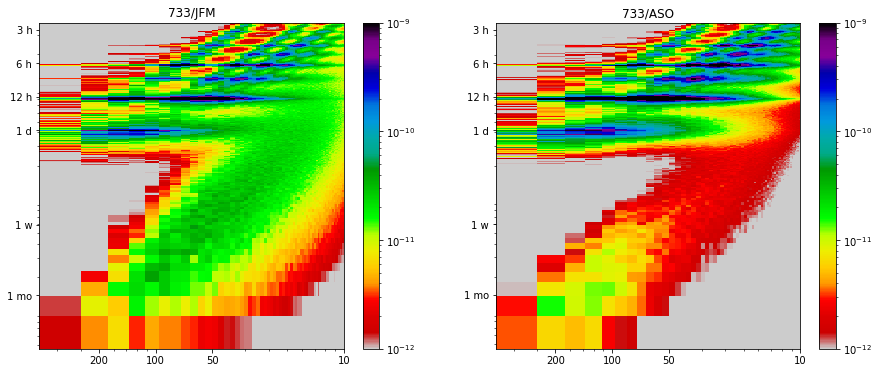

0 JFM
Loading /home/antonio/Tesis/spectra/733/RV_JFM_hours.npz
Loading /home/antonio/Tesis/spectra/733/DIV_JFM_hours.npz
Calculating DIV/RV
min,max DIV/RV values: 1.0 1.0
Spectra shape (144, 943)
1 ASO
Loading /home/antonio/Tesis/spectra/733/RV_ASO_hours.npz
Loading /home/antonio/Tesis/spectra/733/DIV_ASO_hours.npz
Calculating DIV/RV
min,max DIV/RV values: 1.0 1.0
Spectra shape (144, 955)


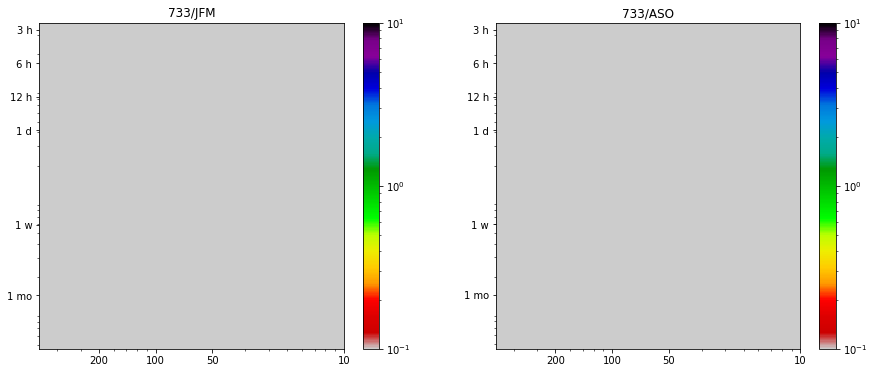

In [186]:
plot_spectra(733,seasons,"KE")
plot_spectra(733,seasons,"RV")
plot_spectra(733,seasons,"DIV")
plot_spectra(733,seasons,"RVDIV")

In [ ]:
for current,r_ids in ids_regions.items():
    if current=="Benguela" or current=="Peru":
        for season in idx_t.keys():
            logging.debug("{},{}".format(current,season))
            for r_id in r_ids:
                calculate_save_spectrum(r_id,season)

In [ ]:
for r_id in ids_regions["California"]:
    plot_spectra(r_id,seasons)

In [ ]:
for r_id in ids_regions["Canarias"]:
    plot_spectra(r_id,seasons)

In [ ]:
for r_id in ids_regions["Peru"]:
    plot_spectra(r_id,seasons)

In [ ]:
for r_id in ids_regions["Benguela"]:
    plot_spectra(r_id,seasons)

In [ ]:
for r_id in ids_regions["Kuroshio"]:
    plot_spectra(r_id,seasons)

In [ ]:
%%script false
%%javascript
var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell:{
        cm_config:{indentUnit: 4} // only change here.
      }
    }
config.update(patch)

// IPython.notebook.save_notebook()

## Histogramas 2D de vorticidad-estiramiento

In [21]:
zrange=(-3.5,3.5)
srange=(0,7)
drange=(-3.5,3.5)
zbins=np.linspace(*zrange)
sbins=np.linspace(*srange)
dbins=np.linspace(*drange)

def zeta_sigma_hist(r_id,season,t_res="days"):
	U,V = UV4id(r_id,season,t_res,t_firstaxis=True)
	grid = VorticityGrid(r_id)
	zeta = grid.rv(U,V)/grid.f
	#delta = grid.div(U,V,DX,DY)/grid.f
	sigma = np.abs(grid.st(U,V)/grid.f) # Se toma abs porque f puede ser negativo, pero suele usarse sigma positivo
	ow = grid.ow(U,V)/(grid.f**2)
	Q0 = np.std(ow)
	sigma_elip = np.sqrt(np.square(zbins)-Q0)
	sigma_hyp = np.sqrt(np.square(zbins)+Q0)
	
	
	#plt.figure(figsize=(15,6))
	#plt.subplot(1,2,1)
	plt.hist2d(zeta.flat[:],sigma.flat[:],bins=[zbins,sbins],density=True,norm=LogNorm(vmin=1e-5),cmap=plt.cm.cubehelix_r)
	plt.colorbar()
	plt.plot(zbins,sigma_elip,color='darkturquoise',linewidth=2)
	plt.plot(zbins,sigma_hyp,color='lightcoral',linewidth=2)
	xlims = list(plt.xlim(zrange))
	ylims = list(plt.ylim(srange))
	yplus = xlims
	yminus = [-1*y for y in yplus]
	#plt.plot([0,0],ylims,linestyle=":",color='k',scalex=False,scaley=False) # Vertical line
	#plt.plot(xlims,yplus,linestyle='--',color='w', scalex=False, scaley=False)
	#plt.plot(xlims,yminus,linestyle='--',color='w', scalex=False, scaley=False)
	plt.xlabel("$\zeta/f$",size="xx-large")
	plt.ylabel("$\sigma/f$",size="xx-large")
	#plt.subplot(1,2,2)
	#plt.hist2d(zeta.flat[:],delta.flat[:],bins=100,density=True,norm=LogNorm(vmin=1e-4),cmap=plt.cm.gnuplot2_r)
	#plt.colorbar()
	#xlims = list(plt.xlim(zrange))
	#ylims = list(plt.ylim(drange))
	#plt.plot([0,0],ylims,linestyle=":",color='k',scalex=False,scaley=False) # Vertical line
	#plt.plot(xlims,[0,0],linestyle=":",color='k',scalex=False,scaley=False) # Horizontal line
	#plt.xlabel("$\zeta/f$",size="xx-large")
	#plt.ylabel("$\delta/f$",size="xx-large")
	plt.title("{} / {}".format(r_id,season),size="xx-large")
	#plt.show()

In [22]:
def plot_2dhists(current,t_res="days"):
	for r_id in ids_regions[current]:
		fig, ax = plt.subplots(1,2,figsize=(12,5))
		ax = ax.flat[:]
		for i,season in enumerate(seasons):
			plt.sca(ax[i])
			zeta_sigma_hist(r_id,season,t_res)
		plt.show()

In [ ]:
plot_2dhists("California")

In [ ]:
plot_2dhists("Canarias")

In [ ]:
plot_2dhists("Peru")

In [ ]:
plot_2dhists("Benguela")

In [ ]:
plot_2dhists("Kuroshio")